# K-Means

In [45]:
import pandas as pd
from numpy import array
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
%matplotlib inline

from sklearn.model_selection import learning_curve

from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import itertools

from scipy import linalg
import matplotlib as mpl
from sklearn import mixture



from sknn import ae, mlp
from sklearn.decomposition import PCA
from sklearn import random_projection

data = pd.read_csv("training.csv")
test = pd.read_csv("testing.csv")
train_columns = data.columns.values.tolist()[1:]
classification_column = data.columns.values.tolist()[0]


X = data[train_columns]
y = data[classification_column]

testing_X = test[train_columns]
testing_y = test[classification_column]

X_old = X

scaling = StandardScaler().fit(X)
X = scaling.transform(X)

true_labels = pd.get_dummies(y, "class")
true_labels = true_labels[true_labels.columns.values.tolist()[-1]].tolist()
print train_columns

test_true_labels = pd.get_dummies(testing_y, "class")
test_true_labels = test_true_labels[test_true_labels.columns.values.tolist()[-1]].tolist()
import subprocess as sp
def notify(msg):
    print sp.Popen('client.exe -alias=ML -msg="{msg}" '.format(msg=msg), shell=True,
                   stdout=sp.PIPE, stderr=sp.PIPE).communicate()
    
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def draw_GM(X, Y_, means, covariances, index, title, size=2, xlim=None, ylim=None):
    _, splot = plt.subplots(1, sharex=True)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], s=size,color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    plt.show()

def draw_kmeans(X, labels, centroids, clusters, title, size=5, xlim=None, ylim=None):
    _, ax1 = plt.subplots(1, sharex=True)
    for i in range(clusters):
        # select only data observations with cluster label == i
        ds = X[np.where(labels==i)]
        # plot the data observations
        ax1.scatter(ds[:,0],ds[:,1],s=size)
        # plot the centroids
        lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
        # make the centroid x's bigger
        plt.setp(lines,ms=15.0)
        plt.setp(lines,mew=2.0)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    plt.show()

['GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan']


In [8]:

def kmeans_cluster(X, true_output):
    param = range(2, 20)
    scores = []
    inertia = []
    for el in param:
        KM = KMeans(n_clusters=el, n_jobs=-1).fit(X)
        label = KM.labels_
        inertia.append(KM.inertia_)
        scores.append(metrics.adjusted_rand_score(true_output, label))
    
    return param, scores, inertia

def kmeans_iter(X, true_output, clusters):
    param = range(5, 100)
    inertia = []
    for el in param:
        KM = KMeans(n_clusters=clusters, max_iter=el, n_jobs=-1, random_state=1).fit(X)
        label = KM.labels_
        inertia.append(KM.inertia_)
    return param, inertia


kmeans_cluster_x, kmeans_cluster_scores, kmeans_cluster_inertia = kmeans_cluster(X, true_labels)
clusters = kmeans_cluster_x[kmeans_cluster_scores.index(max(kmeans_cluster_scores))]
print "done"
kmeans_iter_x, kmeans_iter_inertia = kmeans_iter(X, true_labels, clusters)


done


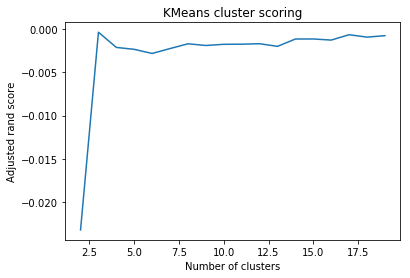

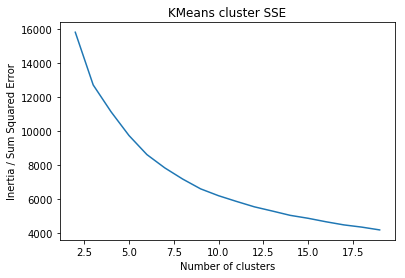

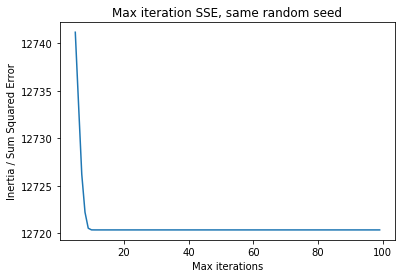

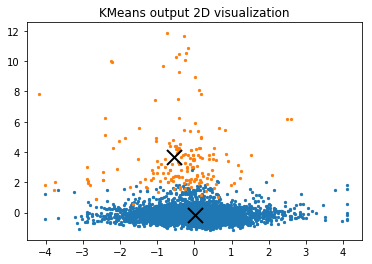

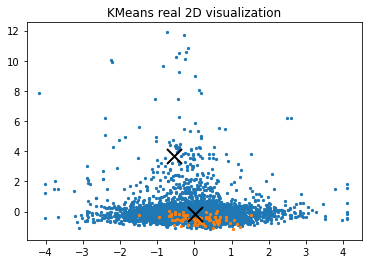

In [80]:
f, ax1 = plt.subplots(1, sharex=True)
ax1.plot(kmeans_cluster_x, kmeans_cluster_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Adjusted rand score")
plt.title("KMeans cluster scoring")
plt.legend()

f, ax1 = plt.subplots(1, sharex=True)
ax1.plot(kmeans_cluster_x, kmeans_cluster_inertia)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia / Sum Squared Error")
plt.title("KMeans cluster SSE")
plt.legend()

f, ax1 = plt.subplots(1, sharex=True)
ax1.plot(kmeans_iter_x, kmeans_iter_inertia)
plt.xlabel("Max iterations")
plt.ylabel("Inertia / Sum Squared Error")
plt.title("Max iteration SSE, same random seed")
plt.legend()

xlim = (-4.5, 4.5)
KM = KMeans(n_clusters=2, n_jobs=-1).fit(X)
draw_kmeans(X, KM.labels_, KM.cluster_centers_, 2, "KMeans output 2D visualization", 5, xlim=xlim)
draw_kmeans(X, np.array(true_labels), KM.cluster_centers_, 2, "KMeans real 2D visualization", 5, xlim=xlim)

# Expectation Maximization

In [9]:

def GM_clusters(X, true_output):
    param = range(2, 20)
    likelihood = []
    scores = []
    for el in param:
        GM = GaussianMixture(n_components=el).fit(X)
        label = GM.predict(X)
        
        likelihood.append(GM.score(X))
        scores.append(metrics.adjusted_rand_score(true_output, label))
    return param, scores, likelihood

def GM_iter(X, true_output, components):
    param = range(1, 100)
    likelihood = []
    for el in param:
        GM = GaussianMixture(n_components=components, max_iter=el, random_state=1).fit(X)
        label = GM.predict(X)

        likelihood.append(GM.score(X))

    return param, likelihood


GM_cluster_x, GM_cluster_scores, GM_cluster_likelihood = GM_clusters(X, true_labels)
components = GM_cluster_x[GM_cluster_scores.index(max(GM_cluster_scores))]
print "Done"
GM_iter_x, GM_iter_likelihood = GM_iter(X, true_labels, components)


Done


C:\Users\DongSon\Anaconda2\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


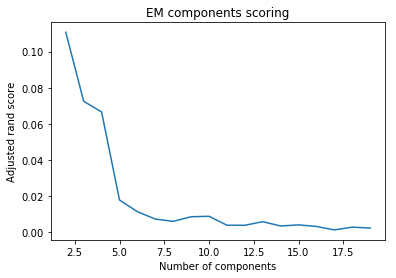

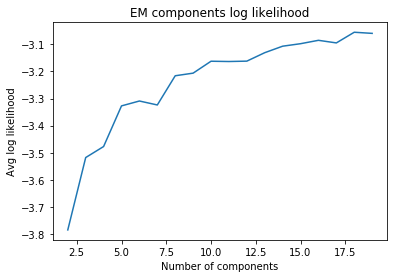

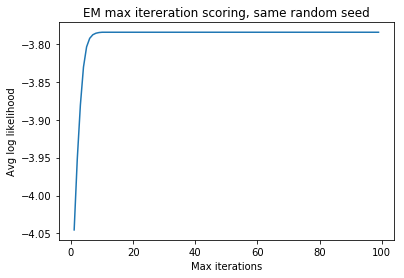

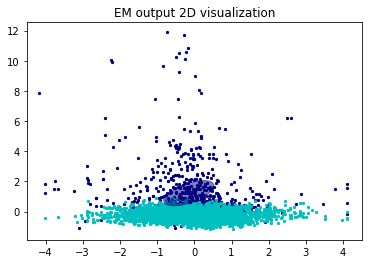

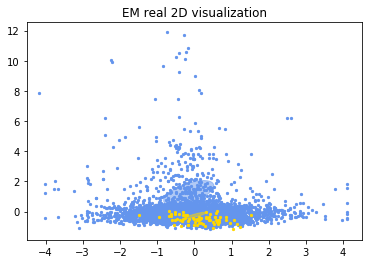

In [47]:
f, ax1 = plt.subplots(1, sharex=True)
ax1.plot(GM_cluster_x, GM_cluster_scores)
plt.xlabel("Number of components")
plt.ylabel("Adjusted rand score")
plt.title("EM components scoring")
plt.legend()

f, ax1 = plt.subplots(1, sharex=True)
ax1.plot(GM_cluster_x, GM_cluster_likelihood)
plt.xlabel("Number of components")
plt.ylabel("Avg log likelihood")
plt.title("EM components log likelihood")
plt.legend()

f, ax1 = plt.subplots(1, sharex=True)
ax1.plot(GM_iter_x, GM_iter_likelihood)
plt.xlabel("Max iterations")
plt.ylabel("Avg log likelihood")
plt.title("EM max itereration scoring, same random seed")
plt.legend()

xlim = (-4.5, 4.5)
GM = GaussianMixture(n_components=2).fit(X)
draw_GM(X, GM.predict(X), GM.means_, GM.covariances_, 1, "EM output 2D visualization", 5, xlim=xlim)
draw_GM(X, np.array(true_labels), GM.means_, GM.covariances_, 1, "EM real 2D visualization", 5, xlim=xlim)

# PCA

C:\Users\DongSon\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


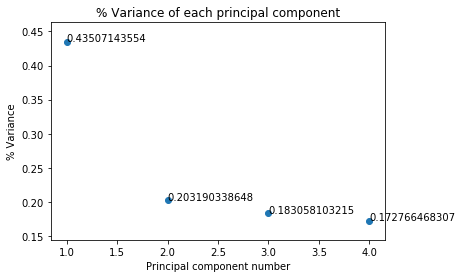

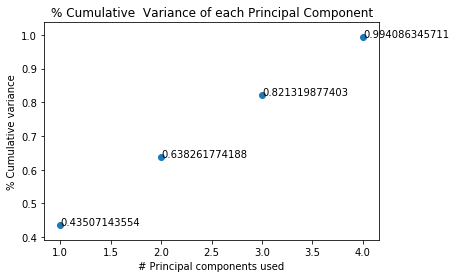

In [19]:
from sklearn.decomposition import PCA

p = PCA(n_components="mle", svd_solver="full").fit(X)

var = p.explained_variance_ratio_
cumsum_var = p.explained_variance_ratio_.cumsum()

f, ax1 = plt.subplots(1, sharex=True)
ax1.scatter(range(1, len(var) + 1), var)
plt.xlabel("Principal component number")
plt.ylabel("% Variance")
plt.title("% Variance of each principal component")
plt.legend()

for i, txt in enumerate(var):
    ax1.annotate(txt, (range(len(var))[i] + 1, var[i]))

f, ax1 = plt.subplots(1, sharex=True)
ax1.scatter(range(1, len(cumsum_var) + 1), cumsum_var)
plt.xlabel("# Principal components used")
plt.ylabel("% Cumulative variance")
plt.title("% Cumulative variance of best principal components")
plt.legend()

for i, txt in enumerate(cumsum_var):
    ax1.annotate(txt, (range(len(cumsum_var))[i] + 1,cumsum_var[i]))


In [11]:
from sklearn.decomposition import PCA
def PCA_kmeans(X, true_output):
    param = range(1, len(X[0]) + 1)
    scores = []
    components = []
    for el in param:
        p = PCA(n_components=el if el != len(X[0]) else "mle", svd_solver="full").fit(X)
        X_new = p.transform(X)
        components.append(p.n_components_)
        
        KM = KMeans(n_clusters=2, n_jobs=-1).fit(X_new)
        label = KM.labels_
        scores.append(metrics.adjusted_rand_score(true_output, label))

    return scores, components

def PCA_GM(X, true_output):
    param = range(1, len(X[0] + 1))
    scores = []
    components = []
    for el in param:
        p = PCA(n_components=el if el != len(X[0]) else "mle", svd_solver="full").fit(X)
        X_new = p.transform(X)
        components.append(p.n_components_)

        GM = GaussianMixture(n_components=2).fit(X_new)
        label = GM.predict(X_new)
        scores.append(metrics.adjusted_rand_score(true_output, label))

    return scores, components



PCA_kmeans_scores, PCA_kmeans_clusters = PCA_kmeans(X, true_labels)
print "done"
PCA_GM_scores, PCA_GM_components = PCA_GM(X, true_labels)

done


[-0.022647896514829822, -0.022760882573944666, -0.023045633985914991, -0.023113252879090315, -0.023179510626591453]
[1, 2, 3, 4, 4]


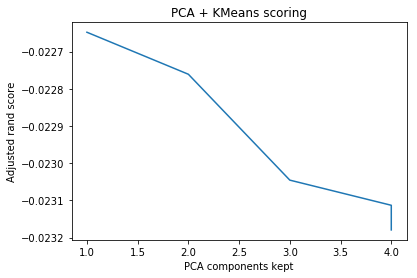

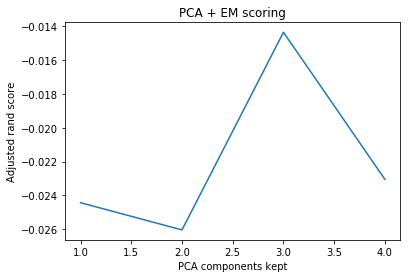

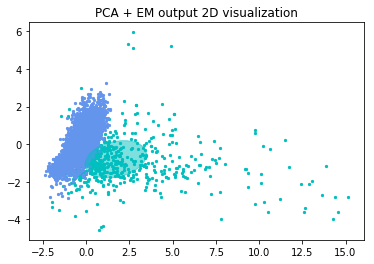

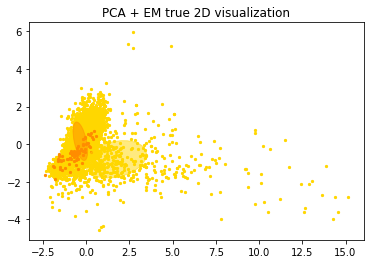

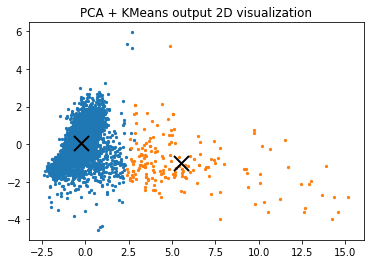

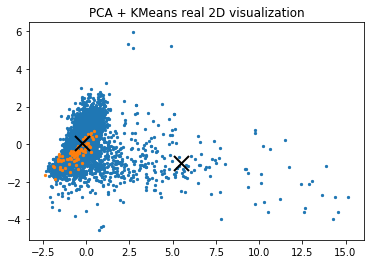

In [88]:
print PCA_kmeans_scores
print PCA_kmeans_clusters
f, ax1 = plt.subplots(1, sharex=True)
ax1.plot(PCA_kmeans_clusters, PCA_kmeans_scores)
plt.xlabel("PCA components kept")
plt.ylabel("Adjusted rand score")
plt.title("PCA + KMeans scoring")
plt.legend()

f, ax1 = plt.subplots(1, sharex=True)
ax1.plot(PCA_GM_components, PCA_GM_scores)
plt.xlabel("PCA components kept")
plt.ylabel("Adjusted rand score")
plt.title("PCA + EM scoring")
plt.legend()

p = PCA(n_components=4, svd_solver="full", random_state=1).fit(X)
X_pca = p.transform(X)


GM = GaussianMixture(n_components=2).fit(X_pca)
draw_GM(X_pca, GM.predict(X_pca), GM.means_, GM.covariances_, 1, "PCA + EM output 2D visualization", 5)
draw_GM(X_pca, np.array(true_labels), GM.means_, GM.covariances_, 1, "PCA + EM true 2D visualization", 5)

KM = KMeans(n_clusters=2, n_jobs=-1).fit(X_pca)
draw_kmeans(X_pca, KM.labels_, KM.cluster_centers_, 2, "PCA + KMeans output 2D visualization", 5)
draw_kmeans(X_pca, np.array(true_labels), KM.cluster_centers_, 2, "PCA + KMeans real 2D visualization", 5)

# Randomized Projections

In [105]:
from sklearn import random_projection

def GRP_kmeans(X, true_output):
    param = range(1, len(X[0]) + 1)
    scores = []
    components = []
    for el in param:
        transformer = random_projection.GaussianRandomProjection(n_components=el).fit(X)
        X_new = transformer.transform(X)
        
        KM = KMeans(n_clusters=2, n_jobs=-1).fit(X_new)
        label = KM.labels_
        scores.append(metrics.adjusted_rand_score(true_output, label))

    return scores, param

def GRP_GM(X, true_output):
    param = range(1, len(X[0]) + 1)
    scores = []
    components = []
    for el in param:
        transformer = random_projection.GaussianRandomProjection(n_components=el).fit(X)
        X_new = transformer.transform(X)

        GM = GaussianMixture(n_components=2).fit(X_new)
        
        label = GM.predict(X_new)
        scores.append(metrics.adjusted_rand_score(true_output, label))

    return scores, param



GRP_kmeans_scores_arr = []; GRP_kmeans_components_arr = []
GRP_GM_scores_arr = []; GRP_GM_components_arr = []

for i in range(5):
    GRP_kmeans_scores, GRP_kmeans_components = GRP_kmeans(X, true_labels)
    GRP_GM_scores, GRP_GM_components = GRP_GM(X, true_labels)
    
    GRP_kmeans_scores_arr.append(GRP_kmeans_scores)
    GRP_kmeans_components_arr.append(GRP_kmeans_components)
    GRP_GM_scores_arr.append(GRP_GM_scores)
    GRP_GM_components_arr.append(GRP_GM_components)

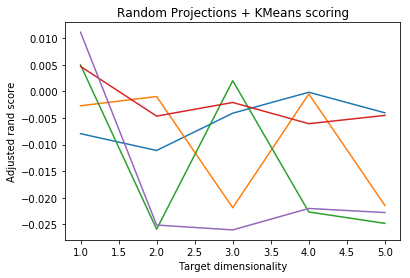

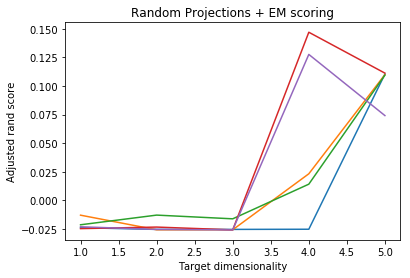

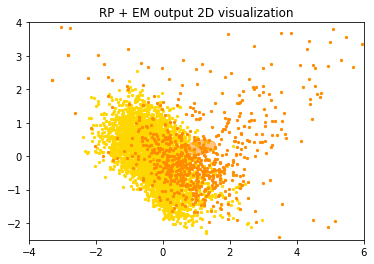

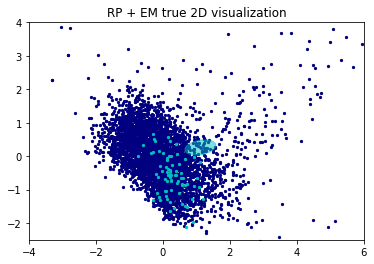

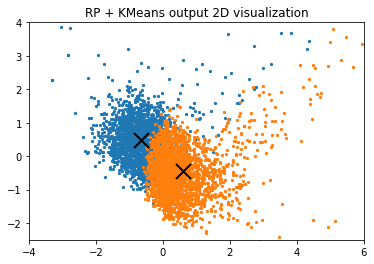

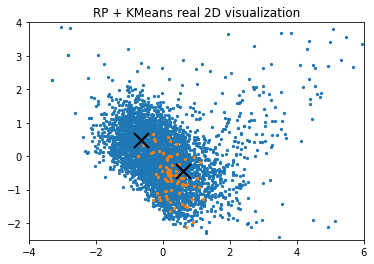

In [110]:

f, ax1 = plt.subplots(1, sharex=True)
for i in range(5):
    ax1.plot(GRP_kmeans_components_arr[i], GRP_kmeans_scores_arr[i])
plt.xlabel("Target dimensionality")
plt.ylabel("Adjusted rand score")
plt.title("Random Projections + KMeans scoring")
plt.legend()

f, ax1 = plt.subplots(1, sharex=True)
for i in range(5):
    ax1.plot(GRP_GM_components_arr[i], GRP_GM_scores_arr[i])
plt.xlabel("Target dimensionality")
plt.ylabel("Adjusted rand score")
plt.title("Random Projections + EM scoring")
plt.legend()


transformer = random_projection.GaussianRandomProjection(n_components=5).fit(X)
X_rp = transformer.transform(X)

xlim = (-4, 6)
ylim = (-2.5, 4)
GM = GaussianMixture(n_components=2).fit(X_rp)
draw_GM(X_rp, GM.predict(X_rp), GM.means_, GM.covariances_, 1, "RP + EM output 2D visualization", 5, xlim, ylim)
draw_GM(X_rp, np.array(true_labels), GM.means_, GM.covariances_, 1, "RP + EM true 2D visualization", 5, xlim, ylim)

KM = KMeans(n_clusters=2, n_jobs=-1).fit(X_rp)
draw_kmeans(X_rp, KM.labels_, KM.cluster_centers_, 2, "RP + KMeans output 2D visualization", 5, xlim, ylim)
draw_kmeans(X_rp, np.array(true_labels), KM.cluster_centers_, 2, "RP + KMeans real 2D visualization", 5, xlim, ylim)

In [111]:
from sknn import ae, mlp

def AE_run(X, true_output, out):
    size = len(X[0])
    param = range(1, size)
    kmeans_scores = []
    GM_scores = []
    for el in param:
        AELayers = [
            ae.Layer("Sigmoid", units=size),
            ae.Layer("Sigmoid", units=out),
            ae.Layer("Sigmoid", units=el)
        ]
        myae = ae.AutoEncoder(layers=AELayers)
        myae.fit(X)
        X_new = myae.transform(X)


        KM = KMeans(n_clusters=2, n_jobs=-1).fit(X_new)
        KM_label = KM.labels_
        kmeans_scores.append(metrics.adjusted_rand_score(true_output, KM_label))
        
        GM = GaussianMixture(n_components=2).fit(X_new)
        GM_label = GM.predict(X_new)
        GM_scores.append(metrics.adjusted_rand_score(true_output, GM_label))
        print el
    
    return param, kmeans_scores, GM_scores

AE_x, AE_kmeans_scores, AE_GM_scores = AE_run(X, true_labels, 2)


1
2
3
4


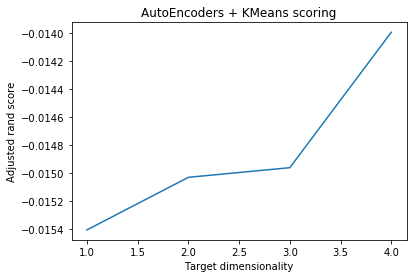

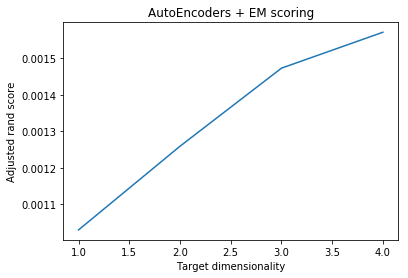

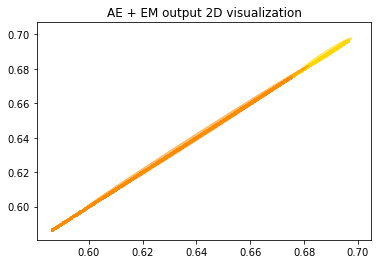

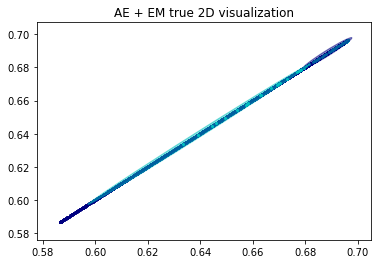

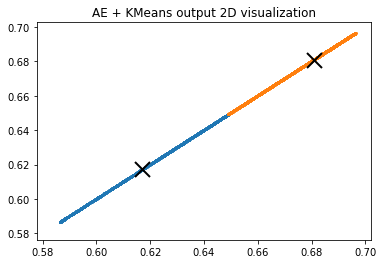

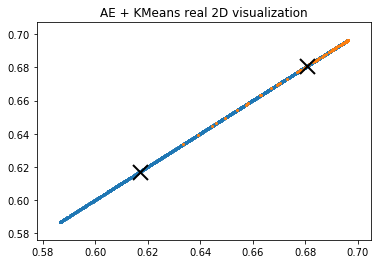

In [116]:
f, ax1 = plt.subplots(1, sharex=True)
ax1.plot(AE_x, AE_kmeans_scores)
plt.xlabel("Target dimensionality")
plt.ylabel("Adjusted rand score")
plt.title("AutoEncoders + KMeans scoring")
plt.legend()

f, ax1 = plt.subplots(1, sharex=True)
ax1.plot(AE_x, AE_GM_scores)
plt.xlabel("Target dimensionality")
plt.ylabel("Adjusted rand score")
plt.title("AutoEncoders + EM scoring")
plt.legend()

layers = [
    ae.Layer("Sigmoid", units=len(X[0])),
    ae.Layer("Sigmoid", units=2),
    ae.Layer("Sigmoid", units=2)
]
myae = ae.AutoEncoder(layers=layers)
myae.fit(X)
X_ae = myae.transform(X)

GM = GaussianMixture(n_components=2).fit(X_ae)
draw_GM(X_ae, GM.predict(X_ae), GM.means_, GM.covariances_, 1, "AE + EM output 2D visualization", 4)
draw_GM(X_ae, np.array(true_labels), GM.means_, GM.covariances_, 1, "AE + EM true 2D visualization", 4)

KM = KMeans(n_clusters=2, n_jobs=-1).fit(X_ae)
draw_kmeans(X_ae, KM.labels_, KM.cluster_centers_, 2, "AE + KMeans output 2D visualization", 4)
draw_kmeans(X_ae, np.array(true_labels), KM.cluster_centers_, 2, "AE + KMeans real 2D visualization", 4)